In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
qc_raw = pd.read_csv("snap_qc_data_2017to2023.csv", encoding = "latin1")

qc = qc_raw[["State", "Year", "Status of Error Findings"]]

qc["Status of Error Findings"] = (
    qc["Status of Error Findings"]
    .astype(str)
    .str.strip()
    .str.lower()
)

print(qc["Status of Error Findings"].value_counts())
print(qc.head(5))

Status of Error Findings
overissuance      47702
underissuance     24283
amount correct       87
Name: count, dtype: int64
         State  Year Status of Error Findings
0  Connecticut  2017             overissuance
1  Connecticut  2017             overissuance
2  Connecticut  2017             overissuance
3  Connecticut  2017             overissuance
4  Connecticut  2017             overissuance


C:\Users\27311\AppData\Local\Temp\ipykernel_24992\829601010.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qc["Status of Error Findings"] = (


In [8]:
def classify_status(x):
    if "over" in x:
        return "Overissue"
    elif "under" in x:
        return "Underissue"
    else:
        return "Correct"

qc["category"] = qc["Status of Error Findings"].apply(classify_status)

print(qc["category"].value_counts())

category
Overissue     47702
Underissue    24283
Correct          87
Name: count, dtype: int64


C:\Users\27311\AppData\Local\Temp\ipykernel_24992\2230062577.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qc["category"] = qc["Status of Error Findings"].apply(classify_status)


In [30]:
# 按州和年统计每种类型的数量
counts = (
    qc.groupby(["State", "Year", "category"])
    .size()
    .reset_index(name="count")
)

# 透视表：每州每年 Overissue / Underissue 两列
pivot = counts.pivot(index=["State", "Year"], columns="category", values="count").fillna(0)

# 计算差值
pivot["diff"] = pivot["Overissue"] - pivot["Underissue"]
pivot["over_ratio"] = pivot["Overissue"] / (pivot["Overissue"] + pivot["Underissue"] + pivot["Correct"])

print(pivot.head())


category      Correct  Overissue  Underissue  diff  over_ratio
State   Year                                                  
Alabama 2017      0.0       61.0        29.0  32.0    0.677778
        2018      0.0       84.0        26.0  58.0    0.763636
        2019      2.0       87.0        27.0  60.0    0.750000
        2020      0.0       75.0        23.0  52.0    0.765306
        2021      0.0       31.0        12.0  19.0    0.720930


In [36]:
avg_diff = pivot.groupby("State")["diff"].mean().reset_index()
avg_diff = avg_diff.sort_values("diff", ascending=False)

avg_ratio = pivot.groupby("State")["over_ratio"].mean().reset_index()
avg_ratio = avg_ratio.sort_values("over_ratio", ascending=True)

print(avg_diff.head())
print(avg_ratio.head())



           State        diff
10       Georgia  202.714286
32    New Mexico  183.142857
40  Rhode Island  163.571429
38        Oregon  149.428571
23      Michigan  144.428571
            State  over_ratio
31     New Jersey    0.485709
52        Wyoming    0.512471
42   South Dakota    0.555409
44          Texas    0.558926
30  New Hampshire    0.568464


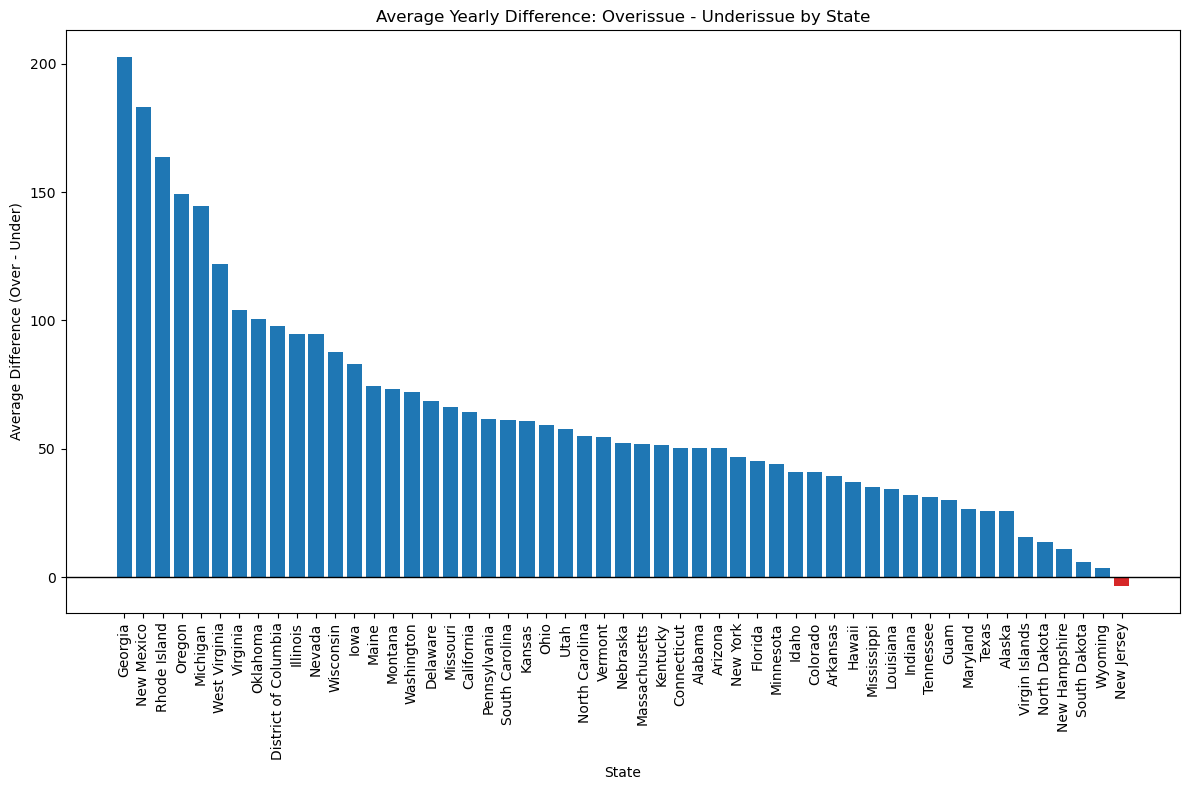

In [16]:
plt.figure(figsize=(12, 8))
plt.bar(avg_diff["State"], avg_diff["diff"], color=["#1f77b4" if x > 0 else "#d62728" for x in avg_diff["diff"]])
plt.xticks(rotation=90)
plt.axhline(0, color="black", linewidth=1)
plt.title("Average Yearly Difference: Overissue - Underissue by State")
plt.ylabel("Average Difference (Over - Under)")
plt.xlabel("State")
plt.tight_layout()
plt.show()


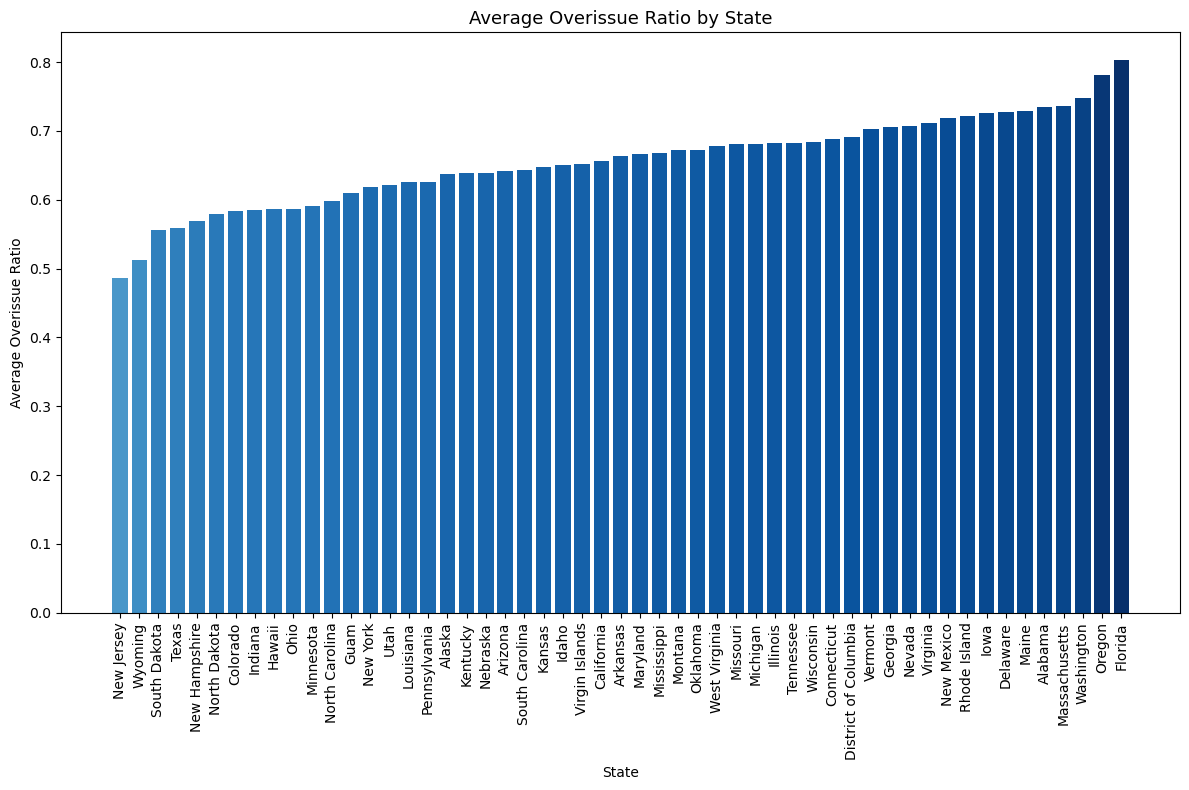

In [40]:
plt.figure(figsize=(12, 8))
plt.bar(
    avg_ratio["State"],
    avg_ratio["over_ratio"],
    color=plt.cm.Blues(avg_ratio["over_ratio"] / avg_ratio["over_ratio"].max())
)

plt.xticks(rotation=90)
plt.title("Average Overissue Ratio by State", fontsize=13)
plt.ylabel("Average Overissue Ratio")
plt.xlabel("State")

plt.tight_layout()
plt.savefig("average_overissue_ratio_by_state.png", dpi=300, bbox_inches="tight")
plt.show()


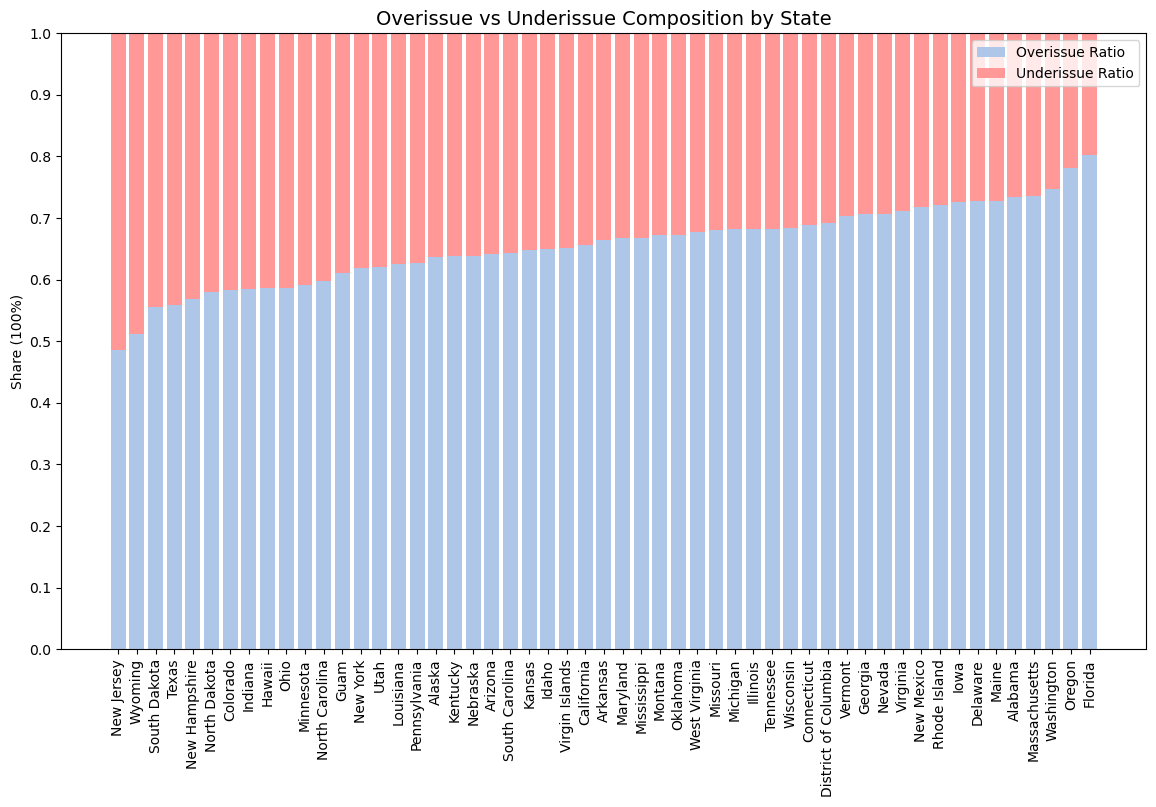

In [54]:
# 确保数据按 over_ratio 排序
avg_ratio = avg_ratio.sort_values("over_ratio", ascending=True)

# 定义颜色
over_color = "#aec7e8"   # 蓝色
under_color = "#ff9896"  # 红色

# 绘图
plt.figure(figsize=(14, 8))

# 蓝色部分（Overissue 比例）
plt.bar(avg_ratio["State"], avg_ratio["over_ratio"], color=over_color, label="Overissue Ratio")

# 红色部分（剩下的 Underissue 部分）
plt.bar(
    avg_ratio["State"],
    1 - avg_ratio["over_ratio"],
    bottom=avg_ratio["over_ratio"],
    color=under_color,
    label="Underissue Ratio"
)

plt.xticks(rotation=90)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Share (100%)")
plt.title("Overissue vs Underissue Composition by State", fontsize=14)
plt.legend(loc="upper right")
plt.ylim(0, 1)  # 确保总高度为100%

plt.tight_layout
plt.savefig("overissue_underissue_composition_by_state.png", dpi=300, bbox_inches="tight")
plt.show()
